In [2]:
import numpy as np
import pandas as pd

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_wind_direction
from functions.data_filtering import complete_flight_filter
from functions.data_processing import get_takeoff_and_landing_directions, prepare_wind_data

from sklearn.model_selection import train_test_split
from sklearn import metrics

from datetime import datetime
from tqdm import tqdm
from traffic.core import Traffic, Flight

In [3]:
origin = "bergen"
destination = "oslo"

unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1))
filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination))
persistences, file_name = get_flight_persistence(filtered_flights, file_name)

In [4]:
origin = "FLESLAND"
destination = "GARDERMOEN"

origin_wind = prepare_wind_data(get_wind_direction(origin))
destination_wind = prepare_wind_data(get_wind_direction(destination))

directions = list(get_takeoff_and_landing_directions(filtered_flights))
dataset = pd.DataFrame(directions)

dataset.rename({0: "start_time",  1: "end_time", 2: "start_direction", 3: "end_direction"}, axis=1, inplace=True)
dataset['start_x'], dataset['start_y']  = np.sin(dataset['start_direction']), np.cos(dataset['start_direction'])
dataset['end_x'], dataset['end_y'] = np.sin(dataset['end_direction']), np.cos(dataset['end_direction'])
dataset['start_time'] = pd.to_datetime(dataset['start_time']).dt.round("s")
dataset['end_time'] = pd.to_datetime(dataset['end_time']).dt.round("s")

merged_start = pd.merge(origin_wind, dataset, how="right", left_on="time", right_on="start_time")
merged_end = pd.merge(destination_wind, dataset, how="right", left_on="time", right_on="end_time")

final_dataset = pd.DataFrame({
    'start_wind_x': merged_start['x'],
    'start_wind_y': merged_start['y'],
    'start_wind_speed': merged_start['wind_speed'],
    'end_wind_x': merged_end['x'],
    'end_wind_y': merged_end['y'],
    'end_wind_speed': merged_end['wind_speed']
}).to_numpy()

In [5]:
rows = []
for flight, wind in tqdm(zip(filtered_flights, final_dataset)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["heading"]), period=2 * np.pi, discont=np.pi)
    unwrapped_diff = unwrapped.max() - unwrapped.min()
    
    length = (data["timestamp"].max() - data["timestamp"].min()).total_seconds()
    
    max_velocity = data["velocity"].max()
    min_velocity = data["velocity"].min()
    
    start_wind_x = wind[0]
    start_wind_y = wind[1]
    start_wind_speed = wind[2]
    end_wind_x = wind[0]
    end_wind_y = wind[1]
    end_wind_speed = wind[2]
    
    row = [unwrapped_diff, length, start_wind_x, start_wind_y, start_wind_speed, end_wind_x, end_wind_y, end_wind_speed]
    rows.append(row)

# Convert the list of rows into a NumPy array
final_array = np.array(rows)

3219it [00:04, 678.76it/s] 


In [6]:
cycle_amount_labels = []
is_cyclic_labels = []
for tree in persistences:
    persistence = tree.persistence()

    more_than_00001 = len([x for x in persistence if  x[0] == 1 and x[1][1] - x[1][0] > 0.0001])
    is_cyclic_labels.append(1 if more_than_00001 else 0)
    cycle_amount_labels.append(more_than_00001)
    
cycle_amount_labels = np.array(cycle_amount_labels)
is_cyclic_labels = np.array(is_cyclic_labels)



In [31]:
x_train, x_val_test, y_train, y_val_test = train_test_split(final_array, cycle_amount_labels, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5)

In [32]:
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

models = {
    "Base line" : [DummyRegressor(strategy = "mean"), {
    
    }],
    "Multi-layer Perception" : [MLPRegressor(random_state=42, max_iter = 10000), {
        "hidden_layer_sizes" : [10, 25, 50], 
    }],
    "K Nearest Neighbors" : [KNeighborsRegressor(), {
        "n_neighbors" : [5, 10, 20, 40], 
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor" : [RandomForestRegressor(random_state=42), {
        "max_depth": [2, 3], 
        "n_estimators" : [50, 100, 300]
    }],
    "Decision Tree Regressor" : [DecisionTreeRegressor(random_state=42), {
        "min_samples_split" : [2, 3, 4],
        "min_samples_leaf" : [1, 2, 3]
    }],
}

In [33]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

datalist = []

for i in models.keys():
    model = GridSearchCV(models[i][0], models[i][1])
    prediction = model.fit(x_train, y_train).predict(x_test)
    
    accuracy = balanced_accuracy_score(y_test, np.round(prediction))
    datalist.append([model.best_estimator_, accuracy])

C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [34]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

DummyRegressor()                                                      :  0.333
MLPRegressor(hidden_layer_sizes=50, max_iter=10000, random_state=42)  :  0.556
KNeighborsRegressor(n_neighbors=40, p=1)                              :  0.495
RandomForestRegressor(max_depth=2, random_state=42)                   :  0.667
DecisionTreeRegressor(min_samples_leaf=2, random_state=42)            :  0.889


In [35]:
x_train_test = np.concatenate([x_train, x_test])
y_train_test = np.concatenate([y_train, y_test])
best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]

prediction = best_model.fit(x_train_test, y_train_test).predict(x_val)
rounded_error = balanced_accuracy_score(y_val, np.round(prediction))
print(f"{best_model.__class__.__name__}: {rounded_error: .3}")

DecisionTreeRegressor:  0.611


C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [36]:
metrics.confusion_matrix(y_val, np.round(prediction))

array([[476,   0,   0,   0],
       [  1,   5,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   1,   0]], dtype=int64)

In [43]:
x_train, x_val_test, y_train, y_val_test = train_test_split(final_array, is_cyclic_labels, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5)

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Base line": [DummyClassifier(strategy="most_frequent"), {

    }],
    "Multi-layer Perception": [MLPClassifier(random_state=42, max_iter=10000), {
        "hidden_layer_sizes": [10, 25, 50],
    }],
    "K Nearest Neighbors": [KNeighborsClassifier(), {
        "n_neighbors": [5, 10, 20, 40],
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor": [RandomForestClassifier(random_state=42), {
        "max_depth": [2, 3],
        "n_estimators": [50, 100, 300]
    }],
    "Decision Tree Regressor": [DecisionTreeClassifier(random_state=42), {
        "min_samples_split": [2, 3, 4],
        "min_samples_leaf": [1, 2, 3]
    }],
}

In [45]:
datalist = []

for i in models.keys():
    model = GridSearchCV(models[i][0], models[i][1])
    prediction = model.fit(x_train, y_train).predict(x_test)

    accuracy = balanced_accuracy_score(y_test, np.round(prediction))
    datalist.append([model.best_estimator_, accuracy])

In [46]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=50, max_iter=10000, random_state=42) :  0.5
KNeighborsClassifier(p=1)                                             :  0.697
RandomForestClassifier(max_depth=3, n_estimators=50, random_state=42) :  0.9
DecisionTreeClassifier(min_samples_leaf=3, random_state=42)           :  1.0


In [47]:
best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]
x_train_test = np.concatenate([x_train, x_test])
y_train_test = np.concatenate([y_train, y_test])

prediction = best_model.fit(x_train_test, y_train_test).predict(x_val)
rounded_error = balanced_accuracy_score(y_val, np.round(prediction))
print(f"{best_model.__class__.__name__}: {rounded_error: .3}")

DecisionTreeClassifier:  0.999


In [48]:
metrics.confusion_matrix(y_val, np.round(prediction))

array([[477,   1],
       [  0,   5]], dtype=int64)

main issue: not enough data with loops! 

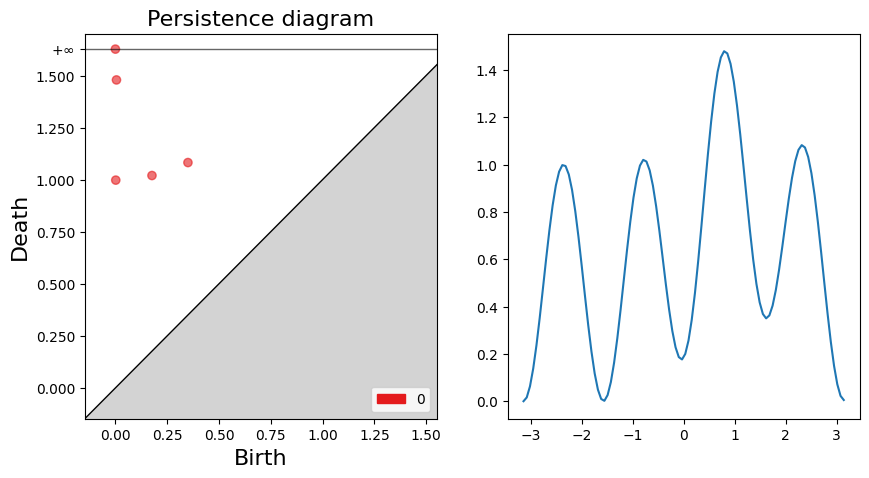

In [6]:
import gudhi
import matplotlib.pyplot as plt
import numpy as np

def build_sublevelset_filtration(Y):
    """
    Y: array-like
        Array of function values
    """
    st = gudhi.SimplexTree()
    for i in range(len(Y)):
        # 0-simplices
        st.insert([i], filtration=Y[i])

        if i < len(Y) - 1:
            # 1-simplices
            st.insert([i, i + 1], filtration=max(Y[i], Y[i + 1]))

    return st

# Create some data
N = 100
f = lambda x: np.sin(2 * x) ** 2 + .5 * np.exp(-(x - 1) ** 2)
X = np.linspace(-np.pi, np.pi, N)
Y = f(X)

# Build sublevelset filtration and compute persistence
st = build_sublevelset_filtration(Y)
diag = st.persistence()

# Plot persistence diagram and function
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
gudhi.plot_persistence_diagram(diag, axes=axs[0])
axs[1].plot(X, Y)
plt.show()

In [7]:
diag

[(0, (1.77667538232862e-08, inf)),
 (0, (0.005094639989002971, 1.478841983822227)),
 (0, (0.0017378695144313035, 0.9977414243024423)),
 (0, (0.17647729136769025, 1.0198051124970193)),
 (0, (0.3501419718978522, 1.0820744049149742))]